# Importing the Modules used in the Project

In [16]:
#Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import os
import PIL as image
import matplotlib.pyplot as plt

#Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import optimizers

#Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skimage.transform import resize

#NN Transfer
from tensorflow.keras.applications import VGG19


In [40]:
def resize(ten, target_size):
    sample = []
    for i in range(ten.shape[0]):
        sample.append(tf.image.resize(ten[i],target_size))
    return np.asarray(sample)

# Importing data from kaggle and defining X_train and y_train

##  Train Data

In [2]:
train_csv = pd.read_csv('train.csv')
train_csv.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [3]:
#Emotion category
emotiondict = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

In [4]:
#Defining y and X

#define response variable and onehotencode it
y = np.asarray(train_csv['emotion'])
y.reshape(28709,1)
y = to_categorical(y)
print("Predictor is One Hot Encoded Shape = {}".format(y.shape))
print(y[0])

Predictor is One Hot Encoded Shape = (28709, 7)
[1. 0. 0. 0. 0. 0. 0.]


In [5]:
table = pd.pivot_table(train_csv, index=['emotion'], aggfunc='size')
print("The number of images under each Category of expression")
print(table)
print(emotiondict)

The number of images under each Category of expression
emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
dtype: int64
{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


In [6]:
#Define predictor variable
#String from the CSV file is split into a 2304 element float32 array
#its then reshaped to into a 48,48 image and then normalized by dividing by 255
X = []
pixel_arr = np.asarray(train_csv['pixels'])
pixel_arr.reshape(28709,1)
for a in pixel_arr:
    X.append(np.asarray(a.split(" "),dtype=np.float32).reshape(48,48))

X = np.asarray(X)

In [7]:
print("Shape of Predictor variable: {}".format(X.shape))

Shape of Predictor variable: (28709, 48, 48)


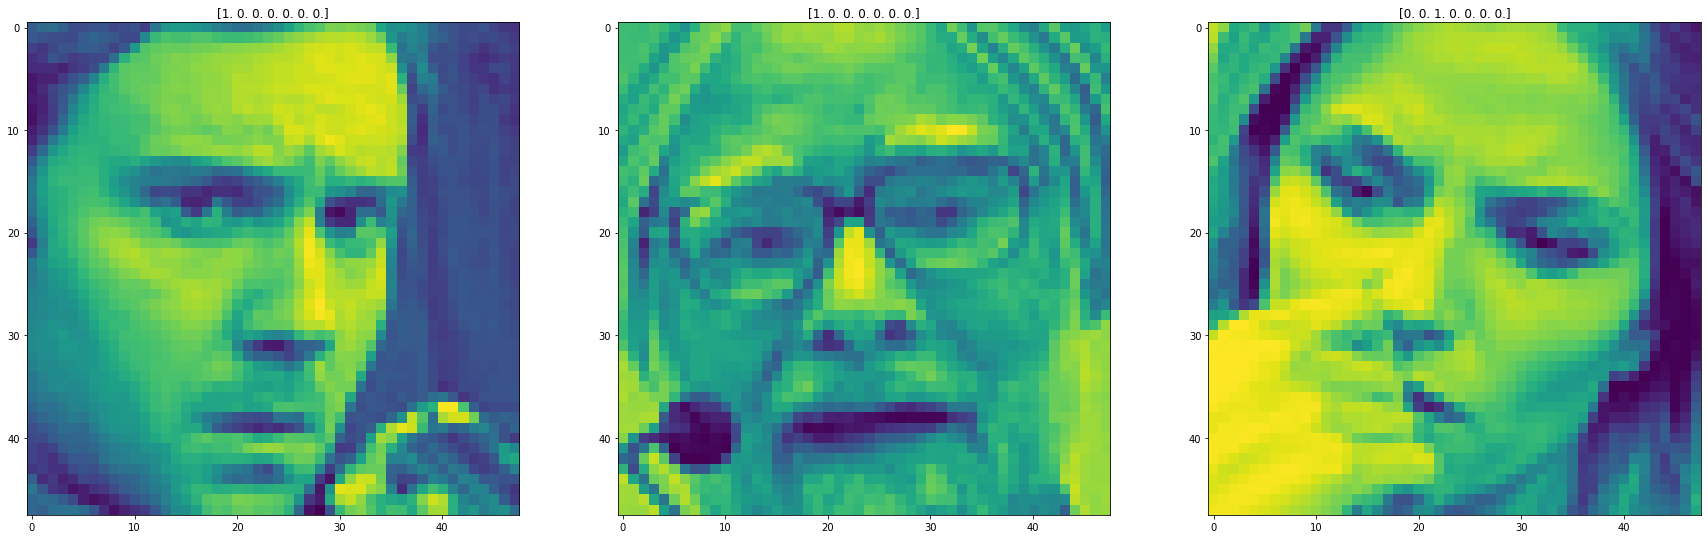

In [8]:
#Plotting three images of the X Dataset with their label
fig, axs = plt.subplots(1,3, figsize=(30,10))
axs[0].imshow(X[0])
axs[0].title.set_text(str(y[0]))
axs[1].imshow(X[1])
axs[1].title.set_text(str(y[1]))
axs[2].imshow(X[2])
axs[2].title.set_text(str(y[2]))

## Test Data


In [9]:
#Defining the test Data set using icml_face_data.csv
data = pd.read_csv('icml_face_data.csv')
test_csv = data.drop(data.index[:28709])
test_csv.head()

,emotion,Usage,pixels
28709,0,PublicTest,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
28710,1,PublicTest,156 184 198 202 204 207 210 212 213 214 215 21...
28711,4,PublicTest,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
28712,6,PublicTest,205 203 236 157 83 158 120 116 94 86 155 180 2...
28713,3,PublicTest,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [10]:
#Defining y_test
y_test = np.asarray(test_csv['emotion'])
y_test.reshape(7178,1)
y_test = np.expand_dims(y_test,1)
y_test = to_categorical(y_test)

In [11]:
#Defining X_test
X_test = []
pixel_arr = np.asarray(test_csv[' pixels'])
pixel_arr.reshape(test_csv.shape[0],1)
for a in pixel_arr:
    X_test.append(np.asarray(a.split(" "),dtype=np.float32).reshape(48,48))

X_test = np.asarray(X_test)
X_test = np.expand_dims(X_test,3)


In [12]:
print("Shape of X_test: {}, y_test: {}".format(X_test.shape,y_test.shape))

Shape of X_test: (7178, 48, 48, 1), y_test: (7178, 7)


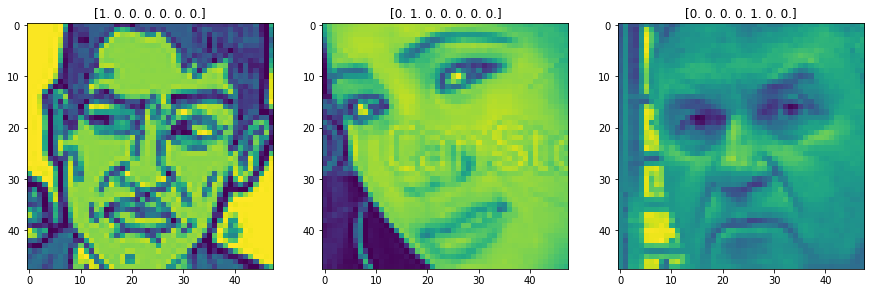

In [13]:
#Plotting 3 images from the test data set
size = X_test[0].shape[0]
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(X_test[0].reshape(size,size))
ax[0].set_title(str(y_test[0]))

ax[1].imshow(X_test[1].reshape(size,size))
ax[1].set_title(str(y_test[1]))

ax[2].imshow(X_test[2].reshape(size,size))
ax[2].set_title(str(y_test[2]))
plt.show()

# Creating Image Data Generators

In [14]:
X = np.expand_dims(X,3)
print("Shapes of X_train: {}, y_train: {}, X_val: {}, y_val: {}".format(X.shape,y.shape,X_test.shape,y_test.shape))

Shapes of X_train: (28709, 48, 48, 1), y_train: (28709, 7), X_val: (7178, 48, 48, 1), y_val: (7178, 7)


In [15]:
#defining Data generators
#Since we are using 4 dimensional numpy arrays the method used will be .flow 
datagen_train = ImageDataGenerator(rescale=1/255.,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=1)
datagen_val = ImageDataGenerator(rescale=1./255)

# Creating the Model

In [33]:
traindata = datagen_train.flow(X,y,shuffle=False,batch_size=64)
testdata = datagen_val.flow(X_test,y_test,shuffle=False,batch_size=64)

In [34]:
model = Sequential()
L2 = tf.keras.regularizers.l2(0.007)
#Conv layer 1
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(48,48,1),kernel_regularizer=L2))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
#Conv Layers
for i in [64,128,256]:
    model.add(Conv2D(i,(3,3),activation='relu',kernel_regularizer=L2))
    model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

#Fully connected Layers
for i in [256,512]:
    model.add(Dense(i,activation='relu',kernel_regularizer=L2))

#Output Layer
model.add(Dense(7,activation='softmax',kernel_regularizer=L2))

In [35]:
#Compile model
model.compile(loss='categorical_crossentropy',optimizer=optimizers.SGD(learning_rate=0.001,momentum=0.9),metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 128)        

In [37]:
#fitting the model
history = model.fit(traindata,
                    epochs=50,
                    validation_data=testdata,
                    verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 449 steps, validate for 113 steps
Epoch 1/50
449/449 - 10s - loss: 7.8145 - accuracy: 0.2552 - val_loss: 7.4514 - val_accuracy: 0.2575
Epoch 2/50
449/449 - 9s - loss: 7.0656 - accuracy: 0.2785 - val_loss: 6.7322 - val_accuracy: 0.2690
Epoch 3/50
449/449 - 9s - loss: 6.3995 - accuracy: 0.3206 - val_loss: 6.0586 - val_accuracy: 0.3452
Epoch 4/50
449/449 - 9s - loss: 5.7801 - accuracy: 0.3649 - val_loss: 5.4830 - val_accuracy: 0.4011
Epoch 5/50
449/449 - 9s - loss: 5.2554 - accuracy: 0.3896 - val_loss: 5.0438 - val_accuracy: 0.3888
Epoch 6/50
449/449 - 9s - loss: 4.8025 - accuracy: 0.4104 - val_loss: 4.5925 - val_accuracy: 0.4067
Epoch 7/50
449/449 - 9s - loss: 4.4114 - accuracy: 0.4234 - val_loss: 4.1941 - val_accuracy: 0.4522
Epoch 8/50
449/449 - 9s - loss: 4.0637 - accuracy: 0.4337 - val_loss: 3.8762 - val_accuracy: 0.4550
Epoch 9/50
449/449 - 9s - loss: 3.7617 - accuracy: 0.4429 - val_loss: 3.7360 - val_accuracy: 0.3876
Epoch

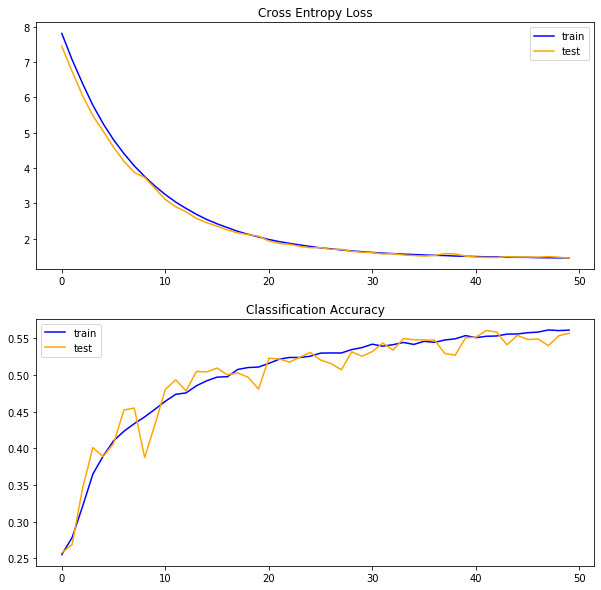

In [38]:
fig, axs = plt.subplots(2,1,figsize=(10,10))
axs[0].title.set_text('Cross Entropy Loss')
axs[0].plot(history.history['loss'], color='blue', label='train')
axs[0].plot(history.history['val_loss'], color='orange', label='test')
axs[0].legend()
axs[1].title.set_text('Classification Accuracy')
axs[1].plot(history.history['accuracy'], color='blue', label='train')
axs[1].plot(history.history['val_accuracy'], color='orange', label='test')
axs[1].legend()

In [39]:
#Evaluate the model
acc = model.evaluate(testdata,verbose=0)
print("Evaluate on test data")
print("Test Loss: {}, Test Acc: {}".format(acc[0],acc[1]))

  ...
    to  
  ['...']
Evaluate on test data
Test Loss: 1.4518333156551935, Test Acc: 0.5569796562194824


# Transfer Learning using VGG19 Network

In [16]:
#Redefining data generators

#Predictor Variables
    #Train
Xt = X
Xt = np.append(Xt,X,axis=3)
Xt = np.append(Xt,X,axis=3)
    #Test
Xt_test = X_test
Xt_test = np.append(Xt_test,X_test,axis=3)
Xt_test = np.append(Xt_test,X_test,axis=3)
#Responce Variables
yt = y
yt_test = y_test
print(f'The shapes of train and test variables: \nX train: {Xt.shape}, y train: {yt.shape} \nX test: {Xt_test.shape}, y test: {y_test.shape}')

The shapes of train and test variables: 
X train: (28709, 48, 48, 3), y train: (28709, 7) 
X test: (7178, 48, 48, 3), y test: (7178, 7)


In [41]:
#Resize all the Responce variables
#Resize is defined above
size=(96,96)
Xt = resize(Xt, size)
Xt_test = resize(Xt_test, size)
print(f'The shapes of train and test variables: \nX train: {Xt.shape}, y train: {yt.shape} \nX test: {Xt_test.shape}, y test: {yt_test.shape}')

NameError: name 'Xt' is not defined

In [19]:
print(f'The shapes of train and test variables: \nX train: {Xt.shape}, y train: {yt.shape} \nX test: {Xt_test.shape}, y test: {yt_test.shape}')

The shapes of train and test variables: 
X train: (28709, 96, 96, 3), y train: (28709, 7) 
X test: (7178, 96, 96, 3), y test: (7178, 7)


In [20]:
#Data Generators
traindata = datagen_train.flow(Xt,yt,shuffle=False,batch_size=64)
testdata = datagen_val.flow(Xt_test,yt_test,shuffle=False,batch_size=64)

In [55]:
#Defining the transefer learning model
modelT = VGG19(include_top=False,input_shape=(96,96,3))
#The following will ensure that all the conv layers of the base VGG19 model will have fixed weights
for layer in modelT.layers:
    layer.trainable=False

In [56]:
#Adding custom FC layers
x = modelT.layers[-1].output
x = Flatten()(x)
#FC layers
for i in [512,128]:
    x = Dense(i,activation='relu')(x)

#Output Layer
x = Dense(7,activation='softmax')(x)

#Define model outputs and inputs
modelT = Model(inputs=modelT.inputs,outputs=x)
modelT.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0   

In [57]:
modelT.compile(loss='categorical_crossentropy',optimizer=optimizers.SGD(0.001,momentum=0.9),metrics=['accuracy'])

In [62]:
historyT = modelT.fit(traindata, 
                      epochs = 100, 
                      validation_data = testdata)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 449 steps, validate for 113 steps
Epoch 1/50
449/449 [==============================] - 61s 135ms/step - loss: 1.3013 - accuracy: 0.5041 - val_loss: 1.3210 - val_accuracy: 0.4891
Epoch 2/50
449/449 [==============================] - 62s 138ms/step - loss: 1.2990 - accuracy: 0.5058 - val_loss: 1.3194 - val_accuracy: 0.4972
Epoch 3/50
449/449 [==============================] - 64s 141ms/step - loss: 1.2996 - accuracy: 0.5034 - val_loss: 1.3184 - val_accuracy: 0.5000
Epoch 4/50
449/449 [==============================] - 64s 143ms/step - loss: 1.2917 - accuracy: 0.5090 - val_loss: 1.3505 - val_accuracy: 0.4767
Epoch 5/50
449/449 [==============================] - 64s 143ms/step - loss: 1.2859 - accuracy: 0.5098 - val_loss: 1.3332 - val_accuracy: 0.4866
Epoch 6/50
449/449 [==============================] - 69s 153ms/step - loss: 1.2897 - accuracy: 0.5099 - val_loss: 1.3196 - val_accuracy: 0.4932
Epoch 7/50
449/449 [================

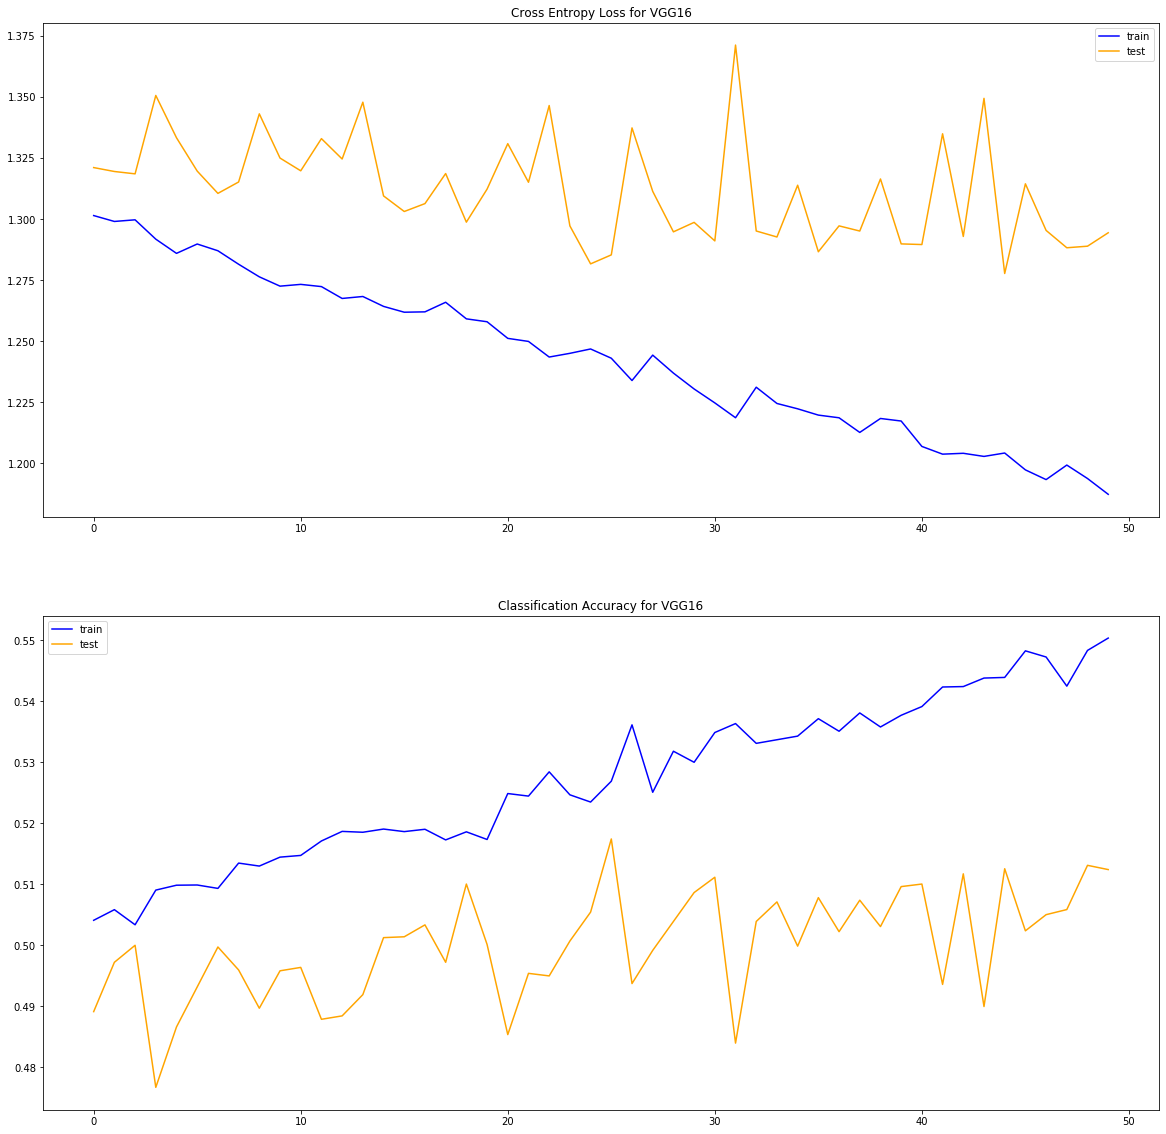

In [63]:
fig, axs = plt.subplots(2,1,figsize=(20,20))
axs[0].title.set_text('Cross Entropy Loss for VGG16')
axs[0].plot(historyT.history['loss'], color='blue', label='train')
axs[0].plot(historyT.history['val_loss'], color='orange', label='test')
axs[0].legend()
axs[1].title.set_text('Classification Accuracy for VGG16')
axs[1].plot(historyT.history['accuracy'], color='blue', label='train')
axs[1].plot(historyT.history['val_accuracy'], color='orange', label='test')
axs[1].legend()

In [64]:
#Evaluate the model
acc = modelT.evaluate(testdata,verbose=0)
print("Evaluate on test data")
print("Test Loss: {}, Test Acc: {}".format(acc[0],acc[1]))

  ...
    to  
  ['...']
Evaluate on test data
Test Loss: 1.2943505112048799, Test Acc: 0.5123990178108215


In [53]:
#Testing the model
yt_pred = modelT.predict(Xt_test)

# Saving the models

In [41]:
model.save('Base_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Base_model\assets


In [65]:
modelT.save('Transfer_model')

INFO:tensorflow:Assets written to: Transfer_model\assets


# Predict Using the trained models

In [43]:
size=48
size_t=96
model = load_model('Base_model')
model_t = load_model('Transfer_model')

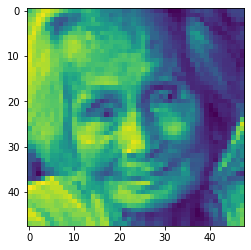

In [36]:
#Take a random number from a uniform distribution and plot the image of that index in the test dataset
x = int(np.random.uniform(0,X_test.shape[0],1))
plt.imshow(X_test[x].reshape(size,size))

In [37]:
#Predict
pred_var = np.expand_dims(X_test[x],0)
pred = model.predict(pred_var)
print(pred)

[[0. 0. 0. 1. 0. 0. 0.]]


In [57]:
org_t = resize(pred_var,(size_t,size_t))
pred_var_t = np.append(org_t,org_t,axis=3)
pred_var_t = np.append(pred_var_t,org_t,axis=3)
print(pred_var_t.shape)

(1, 96, 96, 3)


In [58]:
pred_t = model_t.predict(pred_var_t)
print(pred_t)

[[1.9294498e-26 1.7743377e-31 1.3686680e-03 9.9862635e-01 2.8849612e-08
  4.9159398e-06 3.2199732e-19]]


In [60]:
#Print results
print(f'The Emotion detected using the Base_model is: {emotiondict[np.argmax(pred)]}')
print(f'The Emotion detected using the Transfer_model is: {emotiondict[np.argmax(pred_t)]}')

The Emotion detected using the Base_model is: Happy
The Emotion detected using the Transfer_model is: Happy
